In [1]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import dataFrameTools
import processGen
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
# from cloudpickle import CloudPickler
import tensorflow_probability as tfp
import random
from random import randrange
import checkdf


In [2]:
def loadData2():
    df=dataFrameTools.normalizeDF(0).astype('float32')
    images=[]
    for i in df.index.values:
        filePath=Path("../Processed Images/Grayscale/(" + str(i) + ").png")
        image=cv2.imread(str(filePath),0)
        images.append(image)
    images=np.array(images)
    #scale image values
    images=images/255.0
    split = train_test_split(df, images, test_size=0.3, random_state=42)
    dtrain, dtv, itrain, itv = split
    dtest, dval, itest, ival = train_test_split(dtv, itv, test_size=0.5, random_state=42)
    itrain=tf.expand_dims(itrain, -1)
    ival=tf.expand_dims(ival, -1)
    itest=tf.expand_dims(itest, -1)
    imdims=np.shape(itrain[1])
    ddims=len(dtrain.columns)
    return dtrain,dval,dtest,itrain,ival,itest,imdims,ddims

def custom_sigmoid_cross_entropy_loss_with_logits(x_true, x_recons_logits):
    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true, logits=x_recons_logits)
    if len(np.shape(x_true))==4:
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
    else:
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1])
    return tf.math.reduce_mean(neg_log_likelihood)

In [3]:
class dVAE:
    def __init__(self, datadims, latent_dim, kl_weight, learning_rate):
        self.dim_x = datadims
        self.latent_dim = latent_dim
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
    def encoder(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(self.latent_dim), scale=1.), 
                                reinterpreted_batch_ndims=1)
        
        model=[layers.InputLayer(input_shape=self.dim_x)]
        
        model.append(layers.Dense(200, name="e0"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))

        model.append(layers.Dense(200, name="e1"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="e2"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="e3"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="e4"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(tfp.layers.IndependentNormal.params_size(self.latent_dim), name="e5"))
        
        model.append(tfp.layers.IndependentNormal(self.latent_dim, convert_to_tensor_fn=tfp.distributions.Distribution.sample, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=self.kl_weight), name="e6"))
        return keras.Sequential(model, name='encoder')
    
    
    def decoder(self):
        decoder=keras.Sequential()
        model=[layers.InputLayer(input_shape=(self.latent_dim,))]

        model.append(layers.Dense(200, name="d0"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))

        model.append(layers.Dense(200, name="d1"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="d2"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="d3"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="d4"))
        model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())
        model.append(layers.ReLU())
        model.append(layers.Dropout(0.05))
        
        
        model.append(layers.Dense(self.dim_x, name="d5"))

        return keras.Sequential(model, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = keras.Input(shape=self.dim_x)
        encoder = self.encoder()
        decoder = self.decoder()
#         encoder.summary()
#         decoder.summary()
        z = encoder(x_input)
        output=decoder(z)
        negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
        
        # compile VAE model
        model = keras.Model(inputs=x_input, outputs=output)
        model.compile(loss=custom_sigmoid_cross_entropy_loss_with_logits, optimizer=keras.optimizers.Adam(self.learning_rate))
        return model

In [4]:
dtrain,dval,dtest,itrain,ival,itest,imdims,ddims=loadData2()
dataVAE=dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)
history = dataVAE.fit(x=dtrain, y=dtrain, epochs=5000, batch_size=128, validation_data=(dval, dval), callbacks=[callback])

Loaded Imputed Dataframe in  1.352569341659546 seconds
Epoch 1/5000
25/25 [==============================] - 5s 57ms/step - loss: 1135.9453 - val_loss: 1459.7031
Epoch 2/5000
25/25 [==============================] - 1s 36ms/step - loss: 706.2438 - val_loss: 1128.2327
Epoch 3/5000
25/25 [==============================] - 1s 29ms/step - loss: 631.9193 - val_loss: 852.6050
Epoch 4/5000
25/25 [==============================] - 1s 27ms/step - loss: 606.0478 - val_loss: 674.5402
Epoch 5/5000
25/25 [==============================] - 1s 27ms/step - loss: 595.1235 - val_loss: 616.2988
Epoch 6/5000
25/25 [==============================] - 1s 27ms/step - loss: 587.8666 - val_loss: 600.1950
Epoch 7/5000
25/25 [==============================] - 1s 29ms/step - loss: 581.9352 - val_loss: 588.8083
Epoch 8/5000
25/25 [==============================] - 1s 29ms/step - loss: 578.2958 - val_loss: 581.5446
Epoch 9/5000
25/25 [==============================] - 1s 28ms/step - loss: 575.2858 - val_loss: 577.73

In [14]:
dtrain, dval, dtest, itrain, ival, itest, imdims, ddims = loadData2()
# # Select the row to move
# row_to_move = dval.loc[[1192]]
# # Append the row to dtrain
# dtrain = pd.concat([dtrain, row_to_move], ignore_index=False)
# # Remove the row from dval
# dval = dval.drop(index=1192)

fullVAE = dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model()
data_full = np.concatenate([dtrain, dtest], axis=0) #, dval
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
history = fullVAE.fit(x=data_full, y=data_full, epochs=5000, validation_data=(dval, dval), batch_size=128, callbacks=[callback])

Loaded Imputed Dataframe in  1.3690838813781738 seconds
Epoch 1/5000
30/30 [==============================] - 5s 48ms/step - loss: 1070.4701 - val_loss: 1406.4100
Epoch 2/5000
30/30 [==============================] - 1s 30ms/step - loss: 675.9642 - val_loss: 1030.1843
Epoch 3/5000
30/30 [==============================] - 1s 29ms/step - loss: 618.0068 - val_loss: 735.8496
Epoch 4/5000
30/30 [==============================] - 1s 29ms/step - loss: 597.4251 - val_loss: 627.5261
Epoch 5/5000
30/30 [==============================] - 1s 30ms/step - loss: 587.5490 - val_loss: 603.4945
Epoch 6/5000
30/30 [==============================] - 1s 29ms/step - loss: 581.0078 - val_loss: 588.8549
Epoch 7/5000
30/30 [==============================] - 1s 31ms/step - loss: 576.4805 - val_loss: 579.9485
Epoch 8/5000
30/30 [==============================] - 1s 30ms/step - loss: 573.1050 - val_loss: 575.1223
Epoch 9/5000
30/30 [==============================] - 1s 32ms/step - loss: 570.6472 - val_loss: 570.7

In [6]:
def my_loadData2(bikestyle = None):
    df=dataFrameTools.normalizeDF(0).astype('float32')
    if bikestyle:
        red = pd.read_csv("../data/BIKED_reduced.csv", index_col=0)
        if isinstance(bikestyle, list):
            indices = red[red['BIKESTYLE'].isin(bikestyle)].index
        else:
            indices = red[red['BIKESTYLE'] == bikestyle].index
        
        df = df.loc[indices]

    split = train_test_split(df, test_size=0.3, random_state=42)
    dtrain, dtv, = split
    dtest, dval = train_test_split(dtv, test_size=0.5, random_state=42)
    ddims=len(dtrain.columns)
    return dtrain,dval,dtest,ddims

In [48]:
red = pd.read_csv("../data/BIKED_reduced.csv", index_col=0)

print((red['BIKESTYLE'] == 'BMX').mean())

0.019060283687943262


In [77]:
dtrain, dval, dtest, ddims = my_loadData2(['CITY','COMMUTER','CYCLECROSS', "ROAD",'TOURING', 'TRACK'])

customVAE = dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model()
data_full = np.concatenate([dtrain, dtest], axis=0)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)
history = customVAE.fit(x=data_full, y=data_full, epochs=5000, batch_size=128, validation_data=(dval, dval), callbacks=[callback])

Loaded Imputed Dataframe in  1.4675312042236328 seconds
Epoch 1/5000
18/18 [==============================] - 5s 60ms/step - loss: 1248.2574 - val_loss: 1555.5272
Epoch 2/5000
18/18 [==============================] - 1s 36ms/step - loss: 782.2606 - val_loss: 1319.8086
Epoch 3/5000
18/18 [==============================] - 1s 36ms/step - loss: 665.8892 - val_loss: 1085.8781
Epoch 4/5000
18/18 [==============================] - 1s 36ms/step - loss: 623.9147 - val_loss: 888.1226
Epoch 5/5000
18/18 [==============================] - 1s 36ms/step - loss: 604.3046 - val_loss: 735.4736
Epoch 6/5000
18/18 [==============================] - 1s 37ms/step - loss: 593.4547 - val_loss: 658.3362
Epoch 7/5000
18/18 [==============================] - 1s 36ms/step - loss: 586.3392 - val_loss: 617.9185
Epoch 8/5000
18/18 [==============================] - 1s 36ms/step - loss: 581.7715 - val_loss: 596.9884
Epoch 9/5000
18/18 [==============================] - 1s 37ms/step - loss: 578.6389 - val_loss: 586.

In [72]:
dtrain, dval, dtest, ddims = my_loadData2(['CITY','COMMUTER','CYCLECROSS', "ROAD",'TOURING', 'TRACK'])

customIncDimVAE = dVAE(ddims, 128*2*2, 0.1, 1e-3).build_vae_keras_model()
data_full = np.concatenate([dtrain, dtest], axis=0)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=40)
history = customIncDimVAE.fit(x=data_full, y=data_full, epochs=2000, batch_size=128, validation_data=(dval, dval), callbacks=[callback])

Loaded Imputed Dataframe in  1.429551124572754 seconds
Epoch 1/2000
18/18 [==============================] - 5s 67ms/step - loss: 1250.3527 - val_loss: 1538.4211
Epoch 2/2000
18/18 [==============================] - 1s 38ms/step - loss: 785.2454 - val_loss: 1346.3580
Epoch 3/2000
18/18 [==============================] - 1s 38ms/step - loss: 670.0621 - val_loss: 1124.3755
Epoch 4/2000
18/18 [==============================] - 1s 38ms/step - loss: 628.7557 - val_loss: 916.4763
Epoch 5/2000
18/18 [==============================] - 1s 38ms/step - loss: 608.3870 - val_loss: 761.7157
Epoch 6/2000
18/18 [==============================] - 1s 38ms/step - loss: 596.5936 - val_loss: 669.5798
Epoch 7/2000
18/18 [==============================] - 1s 38ms/step - loss: 588.6794 - val_loss: 623.2999
Epoch 8/2000
18/18 [==============================] - 1s 39ms/step - loss: 583.6708 - val_loss: 601.0991
Epoch 9/2000
18/18 [==============================] - 1s 39ms/step - loss: 579.4785 - val_loss: 589.3

In [40]:
dtrain, dval, dtest, ddims = my_loadData2(['BMX', 'DIRT_JUMP'])

bmx_dirtVAE = dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model()
data_full = np.concatenate([dtrain, dtest], axis=0)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = bmx_dirtVAE.fit(x=data_full, y=data_full, epochs=400, batch_size=128, validation_data=(dval, dval), callbacks=[callback])

Loaded Imputed Dataframe in  1.364546537399292 seconds
Epoch 1/400
3/3 [==============================] - 4s 287ms/step - loss: 1637.8490 - val_loss: 1634.9348
Epoch 2/400
3/3 [==============================] - 0s 41ms/step - loss: 1440.5187 - val_loss: 1619.0656
Epoch 3/400
3/3 [==============================] - 0s 40ms/step - loss: 1274.2213 - val_loss: 1612.6136
Epoch 4/400
3/3 [==============================] - 0s 39ms/step - loss: 1135.4965 - val_loss: 1597.1716
Epoch 5/400
3/3 [==============================] - 0s 39ms/step - loss: 1024.0929 - val_loss: 1580.9144
Epoch 6/400
3/3 [==============================] - 0s 39ms/step - loss: 934.1869 - val_loss: 1556.5432
Epoch 7/400
3/3 [==============================] - 0s 40ms/step - loss: 864.4377 - val_loss: 1527.1719
Epoch 8/400
3/3 [==============================] - 0s 40ms/step - loss: 809.2181 - val_loss: 1492.9263
Epoch 9/400
3/3 [==============================] - 0s 39ms/step - loss: 765.1701 - val_loss: 1450.6271
Epoch 10/400

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

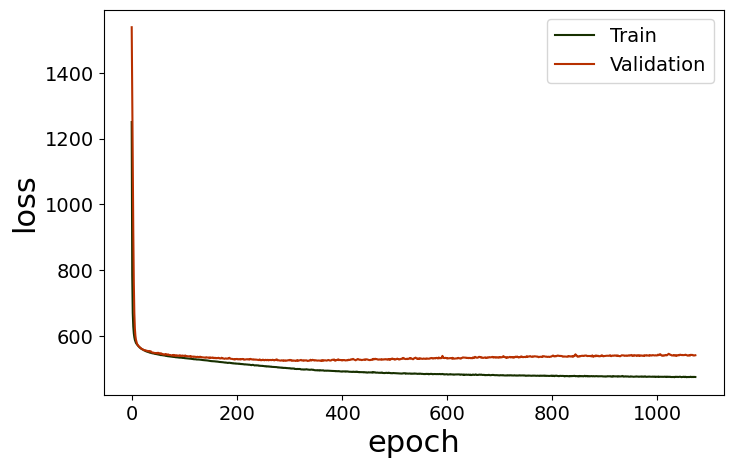

In [74]:
from matplotlib.pyplot import figure
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.rc('axes', labelsize=22)     # fontsize of the axes title
plt.rc('axes', titlesize=22) 
figure(figsize=(8, 5))
plt.plot(history.history['loss'],color='#173000')
plt.plot(history.history['val_loss'], color='#b73000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [15]:
#Random Generation from latent distribution of test batch
df=pd.read_csv("../data/BIKED_normalized.csv", index_col=0)
numgen=10000
# latent=dataVAE.layers[1].predict(dtest.loc[[181,4007]])
latent=dataVAE.layers[1].predict(dtest)
print(np.shape(latent))
generated=np.zeros((numgen, len(latent[0])))
for i in range(numgen):
    for j in range(len(latent[0])):
        idx=randrange(len(latent[:,0]))
        generated[i,j]=latent[idx, j]
res=(tf.math.sigmoid(dataVAE.layers[2].predict(generated))).numpy()
indices=["vaerand" +str(i) for i in range(numgen)]
interpolgendf=pd.DataFrame(res, index=indices, columns=df.columns)
interpolgendf.to_csv("../data/vaeranddf.csv")

22/22 [==============================] - 0s 6ms/step
(677, 128)
313/313 [==============================] - 3s 10ms/step


In [8]:
df=dataFrameTools.loadScaledDF().astype('float32')
dfn=dataFrameTools.normalizeDF(0).astype('float32')
# print(dfn)

Loaded Scaled Dataframe in  1.5776560306549072 seconds
Loaded Imputed Dataframe in  1.4715287685394287 seconds


In [9]:
# Create the latent distribution per latent feature

def get_latent_distribution(latents):
    data = np.stack([np.array(vector) for vector in latents])
    return np.mean(data, axis=0) , np.var(data, axis=0)

In [75]:

onbike = dfn.loc[[41, 101,678,660, 1192, 1388, 1040, 1037]]  #Hand PICKED:41, 101,678,660, 1192, 1388, 1040, 1037]
encoder =  customIncDimVAE.get_layer('encoder')
decoder = customIncDimVAE.get_layer('decoder')
latent = encoder.predict(onbike)  # Correct prediction using encoder

# res = (tf.math.sigmoid(decoder.predict(latent))).numpy()  # Correct use of decoder
# indexnames = ['41', '101','678','660', '1192', '1388', '1040', '1037']  # Ensure this index name is meaningful
# interpolatedf = pd.DataFrame(data=res, index=indexnames, columns=df.columns)  # Correct DataFrame creation
# interpolatedf.to_csv("../data/regen.csv")  # Saving to CSV


# if False:
# processGen.processGen("regen", denorm=True)


if True:
    latent_mean , latent_var = get_latent_distribution(latent)

    numgen = 100
    all_gen = []
    for i in range(numgen):
        all_gen.append([np.random.normal(latent_mean[j], latent_var[j], 1)[0] for j in range(len(latent_mean))])

    res = (tf.math.sigmoid(decoder.predict(all_gen))).numpy()  # Correct use of decoder
    indexnames = ['Dist'+str(i) for i in range(numgen)]  # Ensure this index name is meaningful
    interpolatedf = pd.DataFrame(data=res, index=indexnames, columns=df.columns)  # Correct DataFrame creation
    interpolatedf.to_csv("../data/Dist.csv")  # Saving to CSV
    processed = processGen.processGen("Dist", denorm=True, genbcad=0)
    processed.to_csv("../data/Dist_processed_customInc.csv")  # Saving to CSV

    # if True:
    #     processGen.processGen("Dist", denorm=True)


4/4 [==============================] - 0s 5ms/step
Loaded Imputed Dataframe in  1.4225280284881592 seconds
1.0 fraction valid


c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

One-hot encoding 106 features
Onehot Completed in 0.44185948371887207 seconds
Loaded Imputed Dataframe in  1.5340769290924072 seconds


c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

In [62]:
processGen.processGen("Dist", denorm=True)


Loaded Imputed Dataframe in  1.4505362510681152 seconds
Model Dist67 Seatpost too short
0.99 fraction valid


c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

One-hot encoding 106 features
Onehot Completed in 0.44739556312561035 seconds
Loaded Imputed Dataframe in  1.5364525318145752 seconds


c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

,SSSIDECX3,SSSIDECX2,SSSIDECX1,SSSIDECY2,SSSIDECY1,STEMBENDS,FRONTROTORBOLTS,Shoe up angle,Down tube front diameter,LRTHICK,...,Saddle type OHCLASS: Specialized Jet 143,Saddle type OHCLASS: Specialized Phenom,Saddle type OHCLASS: WILIER Selle Italia,Saddle type OHCLASS: WTB Rocket Vee,Saddle type OHCLASS: fi'zi:k Arione,Saddle type OHCLASS: fi'zi:k Arione TRI,Saddle type OHCLASS: fi'zi:k Gobi,Saddle type OHCLASS: fi'zi:k Tundra,FRONTPANNIER style OHCLASS: 1,BRAZEonFDTYPE OHCLASS: FD9070F
Dist0,89.461622,164.142247,358.433573,25.847320,88.828054,0,6,25,35.344509,10,...,0,0,0,0,0,0,0,0,0,0
Dist1,86.248793,150.356219,308.313779,-4.130921,15.836912,0,6,35,39.516094,10,...,0,0,0,0,0,0,0,0,0,0
Dist2,61.799523,121.156242,270.368310,-16.195976,2.431282,0,6,36,38.123805,10,...,0,0,0,0,0,0,0,0,0,0
Dist3,70.931067,122.686065,271.152612,-14.867165,4.700389,0,6,39,40.050266,10,...,0,0,0,0,0,0,0,0,0,0
Dist4,70.025415,121.001115,286.485116,-8.462967,21.298588,0,6,35,35.590347,10,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dist95,69.008381,143.838351,310.424067,-10.148950,13.678246,0,6,35,37.274286,10,...,0,0,0,0,0,0,0,0,0,0
Dist96,72.593859,133.141297,304.053301,-6.880157,5.862930,0,6,36,39.894457,10,...,0,0,0,0,0,0,0,0,0,0
Dist97,63.045944,121.572042,272.849349,-16.047005,-11.323672,0,6,37,37.665771,10,...,0,0,0,0,0,0,0,0,0,0
Dist98,72.231891,134.259191,287.878269,-8.581569,10.115170,0,6,35,35.845386,10,...,0,0,0,0,0,0,0,0,0,0


In [78]:
# Random sample
num_gen = 100
samples = np.random.normal(loc=0, scale=1, size=(num_gen, 128))
decoder = customVAE.get_layer('decoder')
res = (tf.math.sigmoid(decoder.predict(samples))).numpy()  # Correct use of decoder
indexnames = [f'random_{i}' for i in range(num_gen)]  # Ensure this index name is meaningful
interpolatedf = pd.DataFrame(data=res, index=indexnames, columns=df.columns)  # Correct DataFrame creation
interpolatedf.to_csv("../data/random.csv")  # Saving to CSV
# processGen.processGen("random", denorm=True)

if True:
    processed = processGen.processGen("random", denorm=True, genbcad=0)
    processed.to_csv("../data/random_processed_custom.csv")



4/4 [==============================] - 0s 3ms/step
Loaded Imputed Dataframe in  1.6375932693481445 seconds
1.0 fraction valid


c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

One-hot encoding 106 features
Onehot Completed in 0.46484947204589844 seconds
Loaded Imputed Dataframe in  1.3835384845733643 seconds


c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\BIKED\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

In [192]:
#Interpolation and Extrapolation between two models in Parametric VAE space

twobikes=dtest.loc[[181,4007]]
latent=dataVAE.layers[1].predict(twobikes)
l1=latent[0]
l2=latent[1]
#interpolation code
num_interp=3
interpolated=np.zeros((num_interp, len(l1)))
for i in range(num_interp):
    interpolated[i]=l1+(l2-l1)*(i)/(num_interp+1)
res=(tf.math.sigmoid(dataVAE.layers[2].predict(interpolated))).numpy()
indexnames=[str(i+1)+"Interpolated Latent" for i in range(num_interp)]
interpolatedf=pd.DataFrame(data=res, index=indexnames, columns=df.columns)
interpolatedf.to_csv("../data/interpoldf.csv")

#extrapolation code
num_extrap=3
extrapolated=np.zeros((num_extrap, len(l1)))
for i in range(num_extrap):
    extrapolated[i]=l2+(l2-l1)*(i+1)/3
res=(tf.math.sigmoid(dataVAE.layers[2].predict(extrapolated))).numpy()
indexnames=[str(i+1)+"Extrapolated Latent" for i in range(num_extrap)]
extrapolatedf=pd.DataFrame(data=res, index=indexnames, columns=df.columns)
extrapolatedf.to_csv("../data/extrapoldf.csv")


KeyError: '[181] not in index'

In [ ]:
processGen.processGen("interpoldf")
processGen.processGen("extrapoldf")

Loaded Imputed Dataframe in  0.7721621990203857 seconds
Inverse Scaled Dataframe Successfully exported to CSV in  0.8937671184539795 seconds
One-hot encoding 106 features
Onehot Completed in 3.703176975250244 seconds
Loaded Imputed Dataframe in  0.776667594909668 seconds
1Interpolated Latent
2Interpolated Latent
3Interpolated Latent
Loaded Imputed Dataframe in  0.7881758213043213 seconds
Inverse Scaled Dataframe Successfully exported to CSV in  0.9097800254821777 seconds
One-hot encoding 106 features
Onehot Completed in 3.7417123317718506 seconds
Loaded Imputed Dataframe in  0.7771668434143066 seconds
1Extrapolated Latent
2Extrapolated Latent
3Extrapolated Latent


In [ ]:
#Random latent space sampling code from set range
latent=dataVAE.layers[1].predict(dtest.iloc[[0,1]])[1]
numgen=16
r=np.random.rand(numgen,len(latent))*4-2
res=(tf.math.sigmoid(dataVAE.layers[2].predict(r))).numpy()
indices=["vaerand" +str(i) for i in range(numgen)]
randdf=pd.DataFrame(data=res, columns=dtest.columns, index=indices)
randdf.to_csv("../data/vaeranddf.csv")
# dataFrameTools.deNormalizeDF("randdf.csv")
# dataFrameTools.deOH()
# dataFrameTools.genBCAD()

In [ ]:
processGen.processGen("vaeranddf")

Loaded Imputed Dataframe in  0.769660472869873 seconds
Inverse Scaled Dataframe Successfully exported to CSV in  0.9107804298400879 seconds
One-hot encoding 106 features
Onehot Completed in 3.784749746322632 seconds
Loaded Imputed Dataframe in  0.7991852760314941 seconds
vaerand0
vaerand1
vaerand2
vaerand3
vaerand4
vaerand5
vaerand6
vaerand7
vaerand8
vaerand9
vaerand10
vaerand11
vaerand12
vaerand13
vaerand14
vaerand15


In [ ]:
from sklearn import preprocessing
df=pd.read_csv('../Data/vaeranddf.csv', index_col=0)
ImpDF=dataFrameTools.loadImpDF()
min_max_scaler = preprocessing.MinMaxScaler()
# min_max_scaler = preprocessing.StandardScaler()
min_max_scaler.fit(ImpDF.values)
invscaled=min_max_scaler.inverse_transform(df)   
invdf = pd.DataFrame(invscaled, columns=df.columns, index=df.index.values)
valid=checkvalid(invdf,0)
print(len(valid))
valid=valid[:numgen]
sampled=invdf.loc[valid]
sampled.index=["vae"+ str(i) for i in range(4512)]
# sampled.index=["CTGAN"+ str(i) for i in range(len(sampled.index))]
sampled.to_csv("../data/vaeranddf.csv")

KeyboardInterrupt: 

In [ ]:
class combVAE:
    def __init__(self, comb_input, latent_dim, kl_weight, learning_rate):
        self.comb_input=comb_input
        self.datadims = comb_input[0]
        self.imdims=comb_input[1]
        self.latent_dim = latent_dim
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
        
    def dencoder(self):
        model=[layers.InputLayer(input_shape=self.datadims)]
        
        model.append(layers.Dense(200, name="e0"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.3))

        model.append(layers.Dense(200, name="e1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.3))
        
        model.append(layers.Dense(200, name="e2"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.3))
        
        model.append(layers.Dense(200, name="e3"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.3))
        
        model.append(layers.Dense(200, name="e4"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.3))
        
        return keras.Sequential(model, name='dencoder')
    
    def imencoder(self):
        
        model=[layers.InputLayer(input_shape=self.imdims)]
        
        model.append(layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2),name="e1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))
        
        model.append(layers.Conv2D(filters=128, kernel_size=3, strides=(5, 5),name="e2"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))
        
        model.append(layers.Flatten())
        model.append(layers.Dense(tfp.layers.IndependentNormal.params_size(self.latent_dim), name="e3"))
        
        return keras.Sequential(model, name='imencoder')
        
    def encoder(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(self.latent_dim), scale=1.), 
                                reinterpreted_batch_ndims=1)
        denc=dencoder(self)
        imenc=imencoder(self)
        combinedInput=concatenate([denc.output, imenc.output])
        x=layers.Dense(200, name="f1")(combinedInput)
        x=layers.LeakyReLU()(x)
        x=layers.Dense(tfp.layers.IndependentNormal.params_size(self.latent_dim), name="f1")(x)
        
        x= tfp.layers.IndependentNormal(self.latent_dim, convert_to_tensor_fn=tfp.distributions.Distribution.sample, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=self.kl_weight), name="e6")(x)
        return x
    
    def decoder(self):
        decoder=keras.Sequential()
        model=[layers.InputLayer(input_shape=(self.latent_dim,))]

        model.append(layers.Dense(30*65*32, name="layer1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))

        model.append(layers.Reshape(target_shape=(30, 65, 32)))

        model.append(layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',name="d1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))

        model.append(layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',name="d2"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))

        model.append(layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same',name="d3"))

        return keras.Sequential(model, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = keras.Input(shape=self.comb_input)
        encoder = self.encoder()
        decoder = self.decoder()
        encoder.summary()
        decoder.summary()
        z = encoder(x_input)
        output=decoder(z)
        negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
        
        # compile VAE model
        model = keras.Model(inputs=x_input, outputs=output)
        model.compile(loss=custom_sigmoid_cross_entropy_loss_with_logits, optimizer=keras.optimizers.Adam(self.learning_rate))
        return model

In [ ]:
dtrain,dtest,itrain,itest,imdims,ddims=loadData2()
combdims=[ddims,imdims]
combVAE=combVAE(combdims, 128, 1, 1e-4).build_vae_keras_model()

Loaded Scaled Dataframe in  1.0126619338989258 seconds


TypeError: Error converting shape to a TensorShape: Dimension value must be integer or None or have an __index__ method, got value 'TensorShape([120, 260, 1])' with type '<class 'tensorflow.python.framework.tensor_shape.TensorShape'>'.

In [ ]:
preds=(tf.math.sigmoid(combVAE.predict(x=itest[:16])))
fig = plt.figure(figsize=(25, 15))
for i in range(16):
    idx=dtest.index[i]
    plt.subplot(4, 4, i + 1)
    plt.imshow(preds[i,:,:,:], cmap="gray")
    plt.title("Model " + str(idx), fontsize=20)